# Demo of BSGRU for Two-Tone Sine Wave Prediction
This notebook sets up the demo experiment for training a GRU or a BSGRU to predict the next value for an input sinusoid made up of two tones (e.g., 7 Hz and 10 Hz frequencies).

## Imports 
Running the below cell reloads definitions from `exp_data.py` and `exp_models.py`.

In [1]:
## IMPORTS 
import numpy as np
import torch
import matplotlib.pyplot as plt

from typing import List, Optional, Sequence
import exp_data as D
import exp_models as M
import importlib
importlib.reload(D)
importlib.reload(M)

## DEFINE PROBLEM-SPECIFIC NETWORKS

class SineWaveGRU(torch.nn.Module):
    def __init__(self, hidden_size: int, num_layers: int = 1, num_blocks: int = 1):
        super().__init__()
        self.rnn = torch.nn.GRU(1, hidden_size, num_layers=num_layers,
                                batch_first=True)
        self.dnn = torch.nn.Linear(hidden_size, 1)
    def forward(self, x):
        o, h = self.rnn(x)
        o = torch.tanh(self.dnn(o))
        return o, h, None

class SineWaveBSGRU(torch.nn.Module):
    def __init__(self, hidden_size: int, num_layers: int = 1, num_blocks: int = 1):
        super().__init__()
        self.rnn = M.BSGRUv1(1, hidden_size, num_blocks=num_blocks,
                             num_layers=num_layers, batch_first=True)
        self.dnn = torch.nn.Linear(hidden_size, 1)
    def forward(self, x):
        o, h, m = self.rnn(x)
        o = torch.tanh(self.dnn(o))
        return o, h, m

## Data Prep
This creates the training and test sine wave data using a function from `exp_data.py` (aliased as module `D`).

In [ ]:
frequencies = [7, 10]
tr_x, tr_y, tr_m = D.make_sine_waves(1000, frequencies=frequencies, seed=0)
te_x, te_y, te_m = D.make_sine_waves(10, frequencies=frequencies, seed=1)

## Training
Run the "parameters" cell and the cell below that to kickstart training.

In [2]:
## PARAMETERS [edit here]
learning_rate = 1e-2
hidden_units_per_block = 4
num_blocks = len(frequencies)
run_training = True
max_num_epochs = 50
batch_size = 100

In [3]:
## INSTANTIATE NET, OPTIMIZER, AND LOSS FUNCTION
torch.manual_seed(0)
net = SineWaveBSGRU(hidden_size=num_blocks*hidden_units_per_block,
                    num_blocks=num_blocks).cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
def criterion(
        y_pred: torch.Tensor,
        y_target: torch.Tensor,
        k_model: Optional[torch.Tensor] = None,
        k_label: Optional[torch.Tensor] = None,
        a_reference: float = 0.,
        a_stickiness: float = 0.
) -> torch.Tensor:
    # add signal mean-squared error
    loss = torch.square(y_pred - y_target).mean(dim=2).mean(dim=1)
    # add group reference penalty between k_model and k_label
    if (a_reference > 0) and (k_model is not None) and (k_label is not None):
        loss += a_reference * torch.square(k_model - k_label).mean(dim=2).mean(dim=1)
    # add stickiness penalty on k_model between times {t} and {t-1}
    if (a_stickiness > 0) and (k_model is not None):
        k_norm = torch.linalg.matrix_norm(torch.diff(k_model, dim=1), ord=1)
        loss += a_stickiness * k_norm
    # return batch-wise mean loss tensor
    return torch.mean(loss, dim=0)
print(net)

## RUN TRAINING

if run_training:
    for epoch in range(max_num_epochs):
        
        # shuffle training data
        indices = torch.randperm(len(tr_x))
        _tr_x, _tr_y, _tr_m = tr_x[indices], tr_y[indices], tr_m[indices]
        net.train()
        for b in range(0, len(tr_x), batch_size):

            # make mini-batch
            x = _tr_x[b:b+batch_size]
            y = _tr_y[b:b+batch_size]
            k_true = _tr_m[b:b+batch_size]
            # feed forward
            y_pred, _, k_pred = net(x)
            # loss
            tr_loss = criterion(
                y_pred, y, k_pred[-1], k_true,
                a_reference=0, a_stickiness=1e-3)
            # backprop
            optimizer.zero_grad()
            tr_loss.backward()
            optimizer.step()
        
        # validation
        if not epoch % int(max_num_epochs//10):
            with torch.no_grad():
                net.eval()
                x, y = te_x, te_y
                y_pred, _, _ = net(x)
                te_loss = criterion(y_pred, y).item()
                print(f'TE Loss (#{epoch:04d}):', f'{te_loss:.5g}')
    
    print('Finished training!')

SineWaveBSGRU(
  (rnn): BSGRUv1(
    1, 8, batch_first=True, num_blocks=2
    (layer_0): BSGRUCell(
      (softmax): Softmax(dim=-1)
    )
  )
  (dnn): Linear(in_features=8, out_features=1, bias=True)
)
TE Loss (#0000): 0.50768
TE Loss (#0005): 0.22422
TE Loss (#0010): 0.13753
TE Loss (#0015): 0.16742
TE Loss (#0020): 0.34688
TE Loss (#0025): 0.36465
TE Loss (#0030): 0.12938
TE Loss (#0035): 0.16655
TE Loss (#0040): 0.20006
TE Loss (#0045): 0.24814
Finished training!


## Plotting

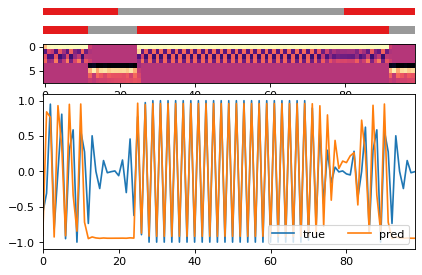

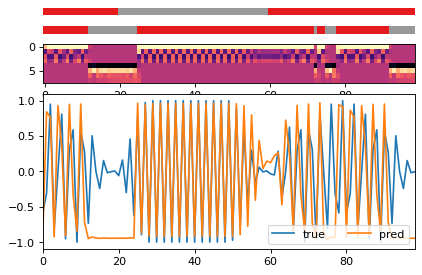

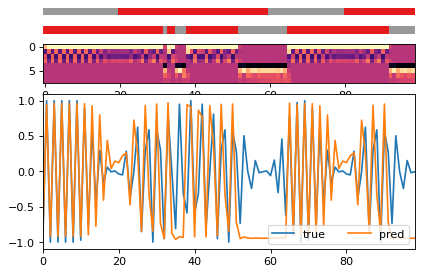

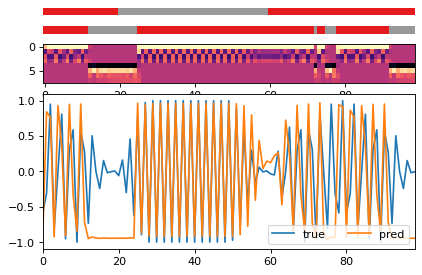

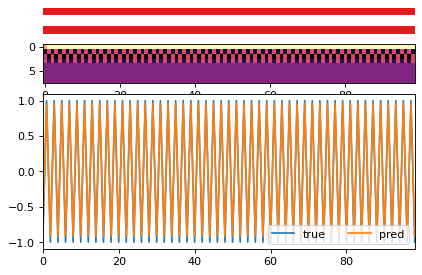

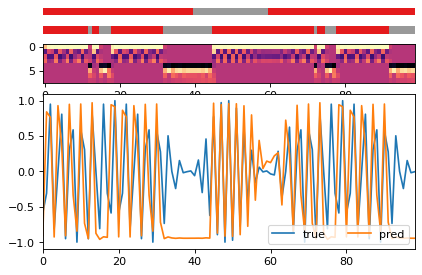

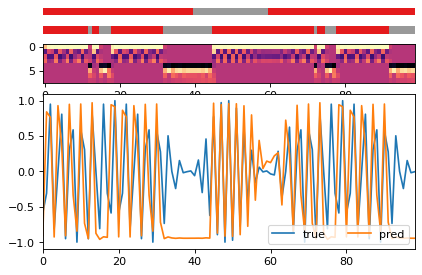

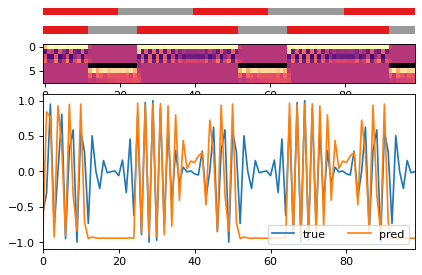

In [4]:
plt.style.use('default')

num_examples = 8

with torch.no_grad():
    net.eval()
    x, y = te_x[:num_examples], te_y[:num_examples]
    y_pred, h, k = net(x)

for i in range(num_examples):
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, height_ratios=[1, 1, 5, 20], dpi=80)
    ax0.imshow(te_m[i].argmax(-1).detach().cpu().numpy()[np.newaxis, :], aspect='auto', interpolation='none', cmap='Set1')
    ax1.imshow(k[0, i].argmax(-1).detach().cpu().numpy()[np.newaxis, :], aspect='auto', interpolation='none', cmap='Set1')
    ax2.imshow(h[0, i].detach().cpu().numpy().T, aspect='auto', interpolation='none', cmap='magma')
    ax0.set_axis_off()
    ax1.set_axis_off()
    ax3.plot(y[i].detach().cpu().numpy(), # /2+.5,
             label='true', zorder=0)
    ax3.plot(y_pred[i].detach().cpu().numpy(), # /2-.5,
             label='pred', zorder=1)
    ax3.margins(x=0)
    ax3.legend(ncols=2, loc=4)
    plt.show()